In [ ]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from ast import dump
import matplotlib.pylab as plt
import joblib
import random
import keras


In [ ]:
train_dir = os.path.join("H:/Projects/Hand sign/new model/asl_alphabet_train/asl_alphabet_train/")
num_class = 29
batch_size = 32
img_height, img_width, k = 200, 200 , 1
train_dir , img_height, img_width, k ,num_class,batch_size

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    interpolation="area",  # Corrected typo here
    validation_split=0.15,
    subset="training",  # Corrected typo here
    seed=42,
    image_size=(img_height, img_width),  # You can uncomment this line if you want to specify the image size
    batch_size = batch_size
    )

test = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    color_mode='grayscale',
    interpolation="area",  # Corrected typo here
    validation_split=0.15,
    subset="training",  # Corrected typo here
    seed=42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)
print(train_ds)
print(train_ds.class_names)

In [4]:
val_batches = tf.data.experimental.cardinality(train_ds)
train_splited = train_ds.take((2*val_batches) // 3)
val_splited = train_ds.skip((2*val_batches) // 3)

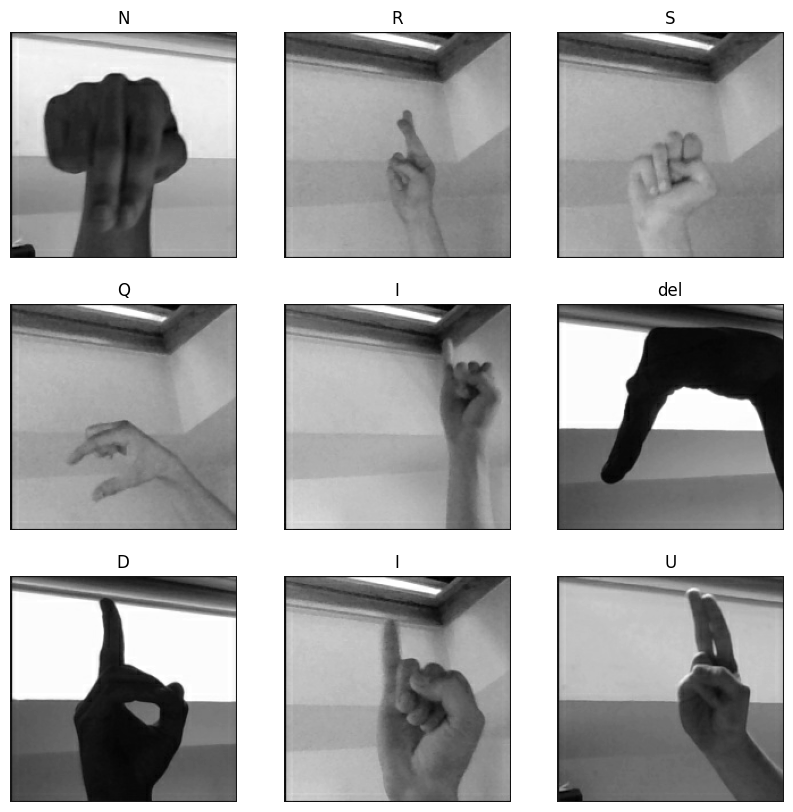

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
    plt.title(train_ds.class_names[labels[i].numpy()])
    plt.axis("off")


In [ ]:
model = tf.keras.models.Sequential()

# Input layer
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, k))),
model.add(tf.keras.layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# Convolutional layers
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(tf.keras.layers.BatchNormalization())

# Fully connected layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(num_class, activation="softmax"))

In [ ]:

# %% Plot and compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)
tf.keras.utils.plot_model(model, "asl_model.png", show_shapes=True)
model.summary()


In [11]:

# %% callbacks
callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=4, min_delta=0.001),
]

In [ ]:
n_epochs=6

new_training=1
if new_training:
    history = model.fit(train_splited,
                        validation_data=val_splited,
                        epochs=n_epochs,
                        callbacks=[callbacks])

In [ ]:
model.evaluate(test)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# epochs_range = range(epochs)
epochs_range = range(len(val_acc))  # Or len(val_loss), or any validation metric


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# %% save 
model.save('model_asl') # save as a folder
joblib.dump(history,'model_asl/history01')
# %%
model.save("model_asl.h5")
# %%